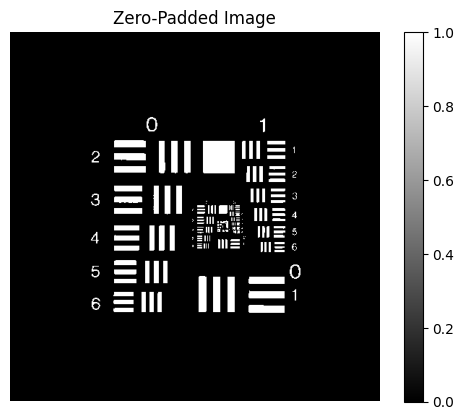

In [ ]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

img = Image.open("USAF.jpg").convert("L")  # "L" mode is grayscale
img_np = np.array(img) / 255.0

img_bin = (img_np < 0.2).astype(np.float32)

# Resize to 350x350
img_resized = cv2.resize(img_bin, (350, 350), interpolation=cv2.INTER_NEAREST)

# Create zero-padded image of size 512x512
padded_img = np.zeros((512, 512), dtype=np.float32)
start_x = (512 - 350) // 2
start_y = (512 - 350) // 2
padded_img[start_y:start_y+350, start_x:start_x+350] = img_resized

# Display the result
plt.imshow(padded_img, cmap='gray')
plt.colorbar()
plt.title("Zero-Padded Image")
plt.axis("off")
plt.show()


In [ ]:

def load_usaf_and_prepare_field(path="USAF.jpg", size=350, pad_size=512):
    img = Image.open(path).convert("L")
    img_np = np.array(img) / 255.0
    img_bin = (img_np > 0.5).astype(np.float32)
    img_resized = cv2.resize(img_bin, (size, size), interpolation=cv2.INTER_NEAREST)

    padded = np.zeros((pad_size, pad_size), dtype=np.float32)
    offset = (pad_size - size) // 2
    padded[offset:offset+size, offset:offset+size] = img_resized
    return padded

def angular_spectrum_propagation(Uin, wavelength, z, dx):
    k = 2 * np.pi / wavelength
    N, M = Uin.shape
    fx = np.fft.fftfreq(M, dx)
    fy = np.fft.fftfreq(N, dx)
    FX, FY = np.meshgrid(fx, fy)
    H = np.exp(1j * z * 2 * np.pi * np.sqrt((1/wavelength)**2 - FX**2 - FY**2, dtype=complex))
    
    Uin_ft = np.fft.fft2(Uin)
    Uout_ft = Uin_ft * H
    Uout = np.fft.ifft2(Uout_ft)
    return np.abs(Uout)

def plot_result(field, title):
    plt.imshow(field, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


In [ ]:

# === Parameters ===
wavelength = 0.5e-6  # 0.5 microns
z = 4 * wavelength

dx_large = 2e-6      # spacing larger than wavelength
dx_small = 0.1e-6    # sub-wavelength spacing
dx_hybrid = 0.37e-6   # hybrid case

# === Load Input Field ===
Uin = load_usaf_and_prepare_field("USAF.jpg")  # binary field

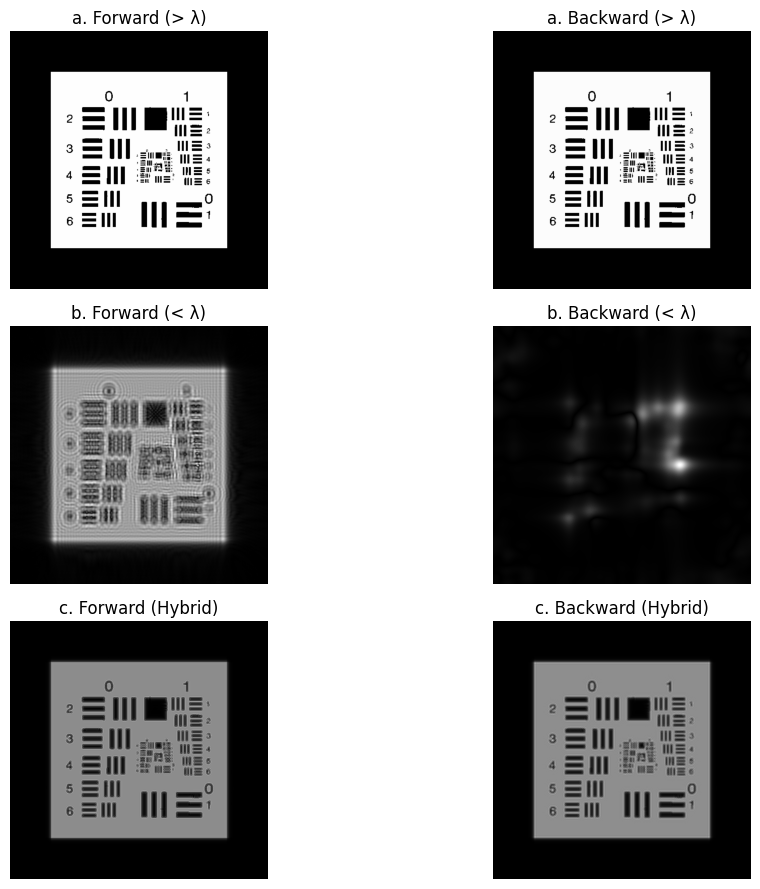

In [ ]:

# Perform forward and backward propagation
U_large = angular_spectrum_propagation(Uin, wavelength, z, dx_large)
U_large_back = angular_spectrum_propagation(U_large, wavelength, -z, dx_large)

U_small = angular_spectrum_propagation(Uin, wavelength, z, dx_small)
U_small_back = angular_spectrum_propagation(U_small, wavelength, -z, dx_small)

U_hybrid = angular_spectrum_propagation(Uin, wavelength, z, dx_hybrid)
U_hybrid_back = angular_spectrum_propagation(U_hybrid, wavelength, -z, dx_hybrid)

# Plot results in a 3x2 grid
fig, axs = plt.subplots(3, 2, figsize=(12, 9))

# Row 1 – Features > λ
axs[0, 0].imshow(np.abs(U_large), cmap='gray')
axs[0, 0].set_title("a. Forward (> λ)")
axs[0, 0].axis("off")

axs[0, 1].imshow(np.abs(U_large_back), cmap='gray')
axs[0, 1].set_title("a. Backward (> λ)")
axs[0, 1].axis("off")

# Row 2 – Features < λ
axs[1, 0].imshow(np.abs(U_small), cmap='gray')
axs[1, 0].set_title("b. Forward (< λ)")
axs[1, 0].axis("off")

axs[1, 1].imshow(np.abs(U_small_back), cmap='gray')
axs[1, 1].set_title("b. Backward (< λ)")
axs[1, 1].axis("off")

# Row 3 – Hybrid case
axs[2, 0].imshow(np.abs(U_hybrid), cmap='gray')
axs[2, 0].set_title("c. Forward (Hybrid)")
axs[2, 0].axis("off")

axs[2, 1].imshow(np.abs(U_hybrid_back), cmap='gray')
axs[2, 1].set_title("c. Backward (Hybrid)")
axs[2, 1].axis("off")

plt.tight_layout()
plt.show()
